In [70]:
import re
from datetime import datetime
import pandas as pd

log_entries = []

# Read the log file
with open('data/haproxy.log', 'r') as file:
    log_entries = file.readlines()

# Define regular expression for field extraction
regex_pattern = r'^(?P<timestamp>\w+\s+\d+\s\d+:\d+:\d+)\s+(?P<server>\S+)\s+haproxy\[\d+\]:\s(?P<client_ip>[\d.:]+):(?P<client_port>\d+)\s+\[(?P<datetime>[^\]]+)\]\s+(?P<frontend>\S+)~\s+(?P<backend>[^\s/]+)/(?P<backendservername>[^\s]+)\s+(?P<timing>[^\s]+)\s+(?P<http_status>\d+)\s+(?P<bytes_read>\d+)\s+.*\s+(?P<act_conn>\d+)/(?P<fe_conn>\d+)/(?P<be_conn>\d+)/(?P<srv_conn>\d+)/(?P<retries>\d+)\s+.*\s+"(?P<request_line>[^"]+)"'

fields = []

# Iterate through log entries
for log_entry in log_entries:
    # Extract fields using regular expression
    match = re.match(regex_pattern, log_entry)
    if match:
        
         # Convert timestamp to datetime value
        timestamp_str = match.group('timestamp')
        timestamp = datetime.strptime(timestamp_str, '%b %d %H:%M:%S')
        # Set the current year as the placeholder
        current_year = datetime.now().year
        timestamp = timestamp.replace(year=current_year)
        
        
         # Convert datetime to datetime value
        datetime_str =  match.group('datetime')
        datetime_format = '%d/%b/%Y:%H:%M:%S.%f'
        mdatetime = datetime.strptime(datetime_str, datetime_format).timestamp()
        
        fields.append({
            'timestamp': timestamp,
            'server': match.group('server'),
            'client_ip': match.group('client_ip'),
            'client_port': int(match.group('client_port')),
            'datetime': mdatetime,
            'frontend': match.group('frontend'),
            'backend': match.group('backend'),
            'backendservername': match.group('backendservername'),
            'timing': match.group('timing'),
            'http_status': int(match.group('http_status')),
            'bytes_read': int(match.group('bytes_read')),
            'request_cookie': '-',
            'response_cookie': '-',
            'termination_state': '-',
            'act_conn': int(match.group('act_conn')),
            'fe_conn': int(match.group('fe_conn')),
            'be_conn': int(match.group('be_conn')),
            'srv_conn': int(match.group('srv_conn')),
            'act_sess': 0,
            'fe_sess': 0,
            'be_sess': 0,
            'srv_sess': 0,
            'retries': int(match.group('retries')),
            'request_line': match.group('request_line')
        })

# Print the first n extracted fields
for field in fields[:1]:
    print(field)
    
# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(fields)

{'timestamp': datetime.datetime(2023, 6, 6, 7, 35, 12), 'server': 'interswitch-virtual-machine', 'client_ip': '41.210.186.148', 'client_port': 51732, 'datetime': 1686026112.147, 'frontend': 'www-https', 'backend': 'interswitchstore_backend', 'backendservername': 'interswitchstore_webserver', 'timing': '371/0/1/37/409', 'http_status': 200, 'bytes_read': 217, 'request_cookie': '-', 'response_cookie': '-', 'termination_state': '-', 'act_conn': 452, 'fe_conn': 452, 'be_conn': 0, 'srv_conn': 1, 'act_sess': 0, 'fe_sess': 0, 'be_sess': 0, 'srv_sess': 0, 'retries': 0, 'request_line': 'POST /interswitchstore/device/remoteConfigs HTTP/1.1'}


In [71]:

# Perform analysis on the DataFrame

# Request Analysis
request_counts = df['request_line'].value_counts()
print("Request Counts:")
print(request_counts)


# Response Analysis
response_counts = df['http_status'].value_counts()
print("\nResponse Counts:")
print(response_counts)

Request Counts:
request_line
POST /api/v1A/svapayments/validateCustomer HTTP/1.1                                                                            572551
POST /interswitchstore/device/trackupdate HTTP/1.1                                                                             140157
POST /interswitchstore/device/geolocationstatus HTTP/1.1                                                                       130513
POST /api/v1A/svapayments/sendAdviceRequest HTTP/1.1                                                                            92300
POST /api/v2/quickteller/agent/agentLogin HTTP/1.1                                                                              89075
                                                                                                                                ...  
GET /api/v2/quickteller/agent/appNotifications/23028645 HTTP/1.1                                                                    1
GET /api/v1A/svapayments/transact

In [65]:
# Timing Analysis
timing_columns = ['act_time', 'fe_time', 'be_time', 'srv_time', 'total_time']
df[timing_columns] = df['timing'].str.split('/', expand=True).astype(int)
timing_summary = df[timing_columns].describe()
print("\nTiming Summary:")
print(timing_summary)


Timing Summary:
         act_time  fe_time   be_time    srv_time  total_time
count    7.000000      7.0  7.000000    7.000000    7.000000
mean    78.857143      0.0  0.714286  166.428571  246.000000
std    135.422091      0.0  0.487950   85.357790   76.826645
min      3.000000      0.0  0.000000   37.000000  173.000000
25%      4.000000      0.0  0.500000  119.000000  209.000000
50%     20.000000      0.0  1.000000  207.000000  237.000000
75%     75.000000      0.0  1.000000  220.500000  242.500000
max    371.000000      0.0  1.000000  242.000000  409.000000


In [66]:
# Connection Analysis
connection_columns = ['act_conn', 'fe_conn', 'be_conn', 'srv_conn']
connection_summary = df[connection_columns].describe()
print("\nConnection Summary:")
print(connection_summary)


Connection Summary:
       act_conn  fe_conn  be_conn  srv_conn
count       7.0      7.0      7.0  7.000000
mean      452.0    452.0      0.0  0.857143
std         0.0      0.0      0.0  0.377964
min       452.0    452.0      0.0  0.000000
25%       452.0    452.0      0.0  1.000000
50%       452.0    452.0      0.0  1.000000
75%       452.0    452.0      0.0  1.000000
max       452.0    452.0      0.0  1.000000


In [67]:
# Bytes Analysis
bytes_summary = df['bytes_read'].describe()
print("\nBytes Summary:")
print(bytes_summary)


Bytes Summary:
count       7.000000
mean      599.571429
std       799.142010
min       217.000000
25%       314.000000
50%       314.000000
75%       314.000000
max      2410.000000
Name: bytes_read, dtype: float64


In [68]:
# Time Series Analysis
df.set_index('timestamp', inplace=True)
df['year'] = df.index.year
yearly_traffic = df.groupby('year').sum()['bytes_read']
print("\nYearly Traffic:")
print(yearly_traffic)


Yearly Traffic:
year
2023    4197
Name: bytes_read, dtype: int64


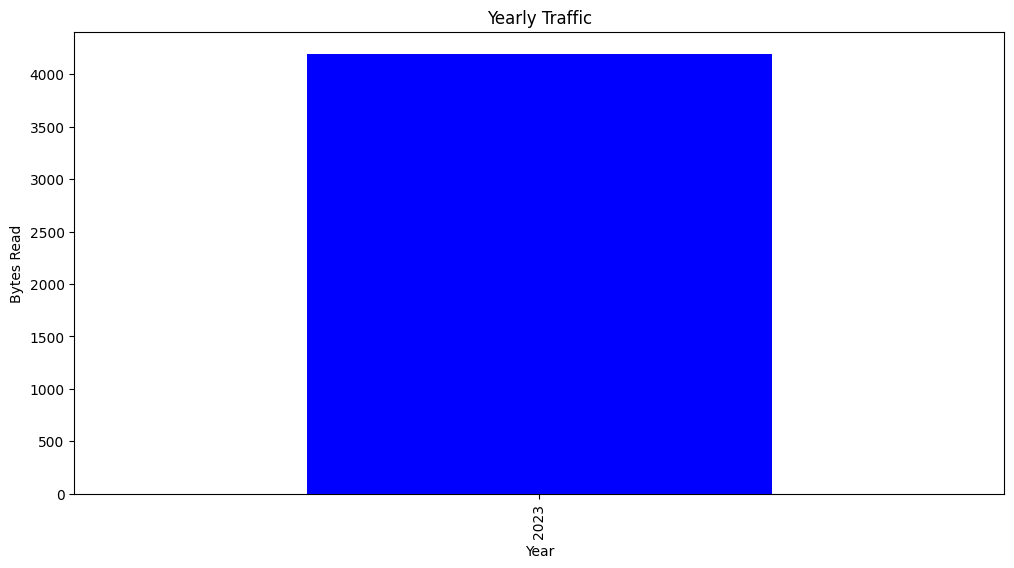

In [69]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 6))
yearly_traffic.plot(kind='bar', color='blue')
plt.title('Yearly Traffic')
plt.xlabel('Year')
plt.ylabel('Bytes Read')
plt.show()